<a href="https://colab.research.google.com/github/EmilyPhang/Social-Media-Computing-Project-Sentiment-Analysis-of-Sephora-Reviews/blob/main/Sentiment_Analysis_(Baseline_Models).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sentiment Analysis Baseline Models
Implements three baseline models for sentiment analysis:
1. Logistic Regression with TF-IDF
2. Support Vector Machine (SVM) with TF-IDF
3. Pretrained BERT as Feature Extractor (No Fine-Tuning)

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from transformers import BertTokenizerFast, BertModel
import torch
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os

In [ ]:
# Set random seed
np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)

In [ ]:
# Load Data
train_df = pd.read_csv('/content/drive/MyDrive/Dataset/train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/Dataset/val.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Dataset/test.csv')

In [ ]:
# Label Encoding
label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['sentiment_label'])
val_df['label'] = label_encoder.transform(val_df['sentiment_label'])
test_df['label'] = label_encoder.transform(test_df['sentiment_label'])

In [ ]:
# Ensure text is string
train_df['cleaned_review'] = train_df['cleaned_review'].astype(str)
val_df['cleaned_review'] = val_df['cleaned_review'].astype(str)
test_df['cleaned_review'] = test_df['cleaned_review'].astype(str)

In [ ]:
# Evaluation Function
def compute_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    acc = accuracy_score(y_true, y_pred)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

def evaluate_model(y_true, y_pred, model_name):
    print(f'\n{model_name} Classification Report:')
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_, digits=4))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    return cm

In [ ]:
# 5.1 Logistic Regression with TF-IDF
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')

# Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
all_preds_lr = []
all_labels_lr = []
results_lr = []
fold = 1

In [ ]:
for train_index, val_index in skf.split(train_df['cleaned_review'], train_df['label']):
    print(f'\nFold {fold}/5 - Logistic Regression')
    train_fold = train_df.iloc[train_index]
    val_fold = train_df.iloc[val_index]

    # TF-IDF transformation
    X_train = tfidf_vectorizer.fit_transform(train_fold['cleaned_review'])
    X_val = tfidf_vectorizer.transform(val_fold['cleaned_review'])
    y_train = train_fold['label']
    y_val = val_fold['label']

    # Train Logistic Regression
    lr_model = LogisticRegression(max_iter=1000, random_state=42)
    lr_model.fit(X_train, y_train)

    # Predict
    val_preds = lr_model.predict(X_val)
    all_preds_lr.extend(val_preds)
    all_labels_lr.extend(y_val)

    # Metrics
    metrics = compute_metrics(y_val, val_preds)
    cm = confusion_matrix(y_val, val_preds)
    if cm.shape[0] == 3:
        tp = np.diag(cm).sum()
        fn = cm.sum(axis=1) - np.diag(cm)
        fp = cm.sum(axis=0) - np.diag(cm)
        tn = cm.sum() - (fp + fn + np.diag(cm))
        fn = fn.sum()
        fp = fp.sum()
        tn = tn.sum()
    else:
        tn, fp, fn, tp = [0] * 4

    results_lr.append({
        'Fold': fold,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1 Score': metrics['f1'],
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn
    })
    fold += 1


Fold 1/5 - Logistic Regression

Fold 2/5 - Logistic Regression

Fold 3/5 - Logistic Regression

Fold 4/5 - Logistic Regression

Fold 5/5 - Logistic Regression


In [ ]:
# Display Results
results_lr_df = pd.DataFrame(results_lr)
avg_row = results_lr_df[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'TP', 'TN', 'FP', 'FN']].mean()
avg_row['Fold'] = 'Average'
results_lr_df = pd.concat([results_lr_df, pd.DataFrame([avg_row])], ignore_index=True)
print('\nLogistic Regression 5-Fold Cross-Validation Results:')
print(results_lr_df)


Logistic Regression 5-Fold Cross-Validation Results:
      Fold  Accuracy  Precision    Recall  F1 Score     TP      TN     FP  \
0        1  0.651709   0.646477  0.651709  0.648227  610.0  1546.0  326.0   
1        2  0.678419   0.678704  0.678419  0.678558  635.0  1571.0  301.0   
2        3  0.657051   0.654169  0.657051  0.655340  615.0  1551.0  321.0   
3        4  0.642094   0.640833  0.642094  0.641220  601.0  1537.0  335.0   
4        5  0.675214   0.672782  0.675214  0.673781  632.0  1568.0  304.0   
5  Average  0.660897   0.658593  0.660897  0.659425  618.6  1554.6  317.4   

      FN  
0  326.0  
1  301.0  
2  321.0  
3  335.0  
4  304.0  
5  317.4  


In [ ]:
# Final Model Training
X_train_full = tfidf_vectorizer.fit_transform(train_df['cleaned_review'])
X_val = tfidf_vectorizer.transform(val_df['cleaned_review'])
X_test = tfidf_vectorizer.transform(test_df['cleaned_review'])
y_train_full = train_df['label']
y_val = val_df['label']
y_test = test_df['label']

lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_full, y_train_full)
test_preds_lr = lr_model.predict(X_test)


Logistic Regression Classification Report:
              precision    recall  f1-score   support

    negative     0.6905    0.6865    0.6885       520
     neutral     0.5827    0.5558    0.5689       520
    positive     0.7495    0.7885    0.7685       520

    accuracy                         0.6769      1560
   macro avg     0.6742    0.6769    0.6753      1560
weighted avg     0.6742    0.6769    0.6753      1560



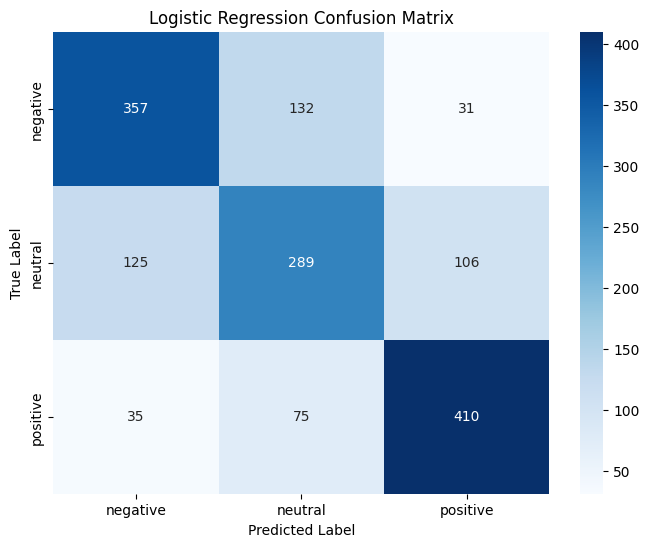

array([[357, 132,  31],
       [125, 289, 106],
       [ 35,  75, 410]])

In [ ]:
# Evaluate
evaluate_model(y_test, test_preds_lr, 'Logistic Regression')

In [ ]:
# Save Model
save_directory = '/content/drive/MyDrive/baseline_models/logistic_regression'
os.makedirs(save_directory, exist_ok=True)
with open(f'{save_directory}/lr_model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)
with open(f'{save_directory}/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
print(f'Logistic Regression model and vectorizer saved to {save_directory}')

Logistic Regression model and vectorizer saved to /content/drive/MyDrive/baseline_models/logistic_regression


In [ ]:
# 5.2 Support Vector Machine (SVM) with TF-IDF
# Cross-Validation
all_preds_svm = []
all_labels_svm = []
results_svm = []
fold = 1

In [ ]:
for train_index, val_index in skf.split(train_df['cleaned_review'], train_df['label']):
    print(f'\nFold {fold}/5 - SVM')
    train_fold = train_df.iloc[train_index]
    val_fold = train_df.iloc[val_index]

    # TF-IDF transformation
    X_train = tfidf_vectorizer.fit_transform(train_fold['cleaned_review'])
    X_val = tfidf_vectorizer.transform(val_fold['cleaned_review'])
    y_train = train_fold['label']
    y_val = val_fold['label']

    # Train SVM
    svm_model = LinearSVC(max_iter=1000, random_state=42)
    svm_model.fit(X_train, y_train)

    # Predict
    val_preds = svm_model.predict(X_val)
    all_preds_svm.extend(val_preds)
    all_labels_svm.extend(y_val)

    # Metrics
    metrics = compute_metrics(y_val, val_preds)
    cm = confusion_matrix(y_val, val_preds)
    if cm.shape[0] == 3:
        tp = np.diag(cm).sum()
        fn = cm.sum(axis=1) - np.diag(cm)
        fp = cm.sum(axis=0) - np.diag(cm)
        tn = cm.sum() - (fp + fn + np.diag(cm))
        fn = fn.sum()
        fp = fp.sum()
        tn = tn.sum()
    else:
        tn, fp, fn, tp = [0] * 4

    results_svm.append({
        'Fold': fold,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1 Score': metrics['f1'],
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn
    })
    fold += 1


Fold 1/5 - SVM

Fold 2/5 - SVM

Fold 3/5 - SVM

Fold 4/5 - SVM

Fold 5/5 - SVM


In [ ]:
# Display Results
results_svm_df = pd.DataFrame(results_svm)
avg_row = results_svm_df[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'TP', 'TN', 'FP', 'FN']].mean()
avg_row['Fold'] = 'Average'
results_svm_df = pd.concat([results_svm_df, pd.DataFrame([avg_row])], ignore_index=True)
print('\nSVM 5-Fold Cross-Validation Results:')
print(results_svm_df)


SVM 5-Fold Cross-Validation Results:
      Fold  Accuracy  Precision    Recall  F1 Score     TP      TN     FP  \
0        1  0.633547   0.627820  0.633547  0.629637  593.0  1529.0  343.0   
1        2  0.652778   0.654452  0.652778  0.653364  611.0  1547.0  325.0   
2        3  0.644231   0.639914  0.644231  0.640556  603.0  1539.0  333.0   
3        4  0.630342   0.628113  0.630342  0.629081  590.0  1526.0  346.0   
4        5  0.632479   0.627146  0.632479  0.629019  592.0  1528.0  344.0   
5  Average  0.638675   0.635489  0.638675  0.636331  597.8  1533.8  338.2   

      FN  
0  343.0  
1  325.0  
2  333.0  
3  346.0  
4  344.0  
5  338.2  


In [ ]:
# Final Model Training
svm_model = LinearSVC(max_iter=1000, random_state=42)
svm_model.fit(X_train_full, y_train_full)
test_preds_svm = svm_model.predict(X_test)


SVM Classification Report:
              precision    recall  f1-score   support

    negative     0.6420    0.6519    0.6469       520
     neutral     0.5613    0.5192    0.5395       520
    positive     0.7441    0.7885    0.7656       520

    accuracy                         0.6532      1560
   macro avg     0.6492    0.6532    0.6507      1560
weighted avg     0.6492    0.6532    0.6507      1560



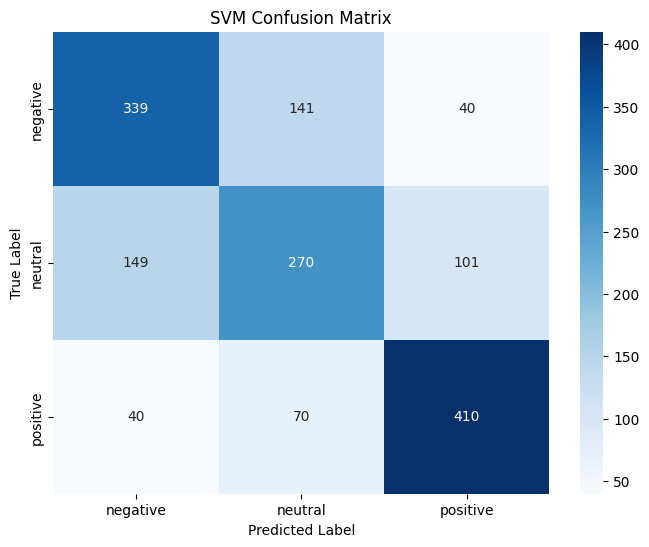

array([[339, 141,  40],
       [149, 270, 101],
       [ 40,  70, 410]])

In [ ]:
# Evaluate
evaluate_model(y_test, test_preds_svm, 'SVM')

In [ ]:
# Save Model
save_directory = '/content/drive/MyDrive/baseline_models/svm'
os.makedirs(save_directory, exist_ok=True)
with open(f'{save_directory}/svm_model.pkl', 'wb') as f:
    pickle.dump(svm_model, f)
with open(f'{save_directory}/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
print(f'SVM model and vectorizer saved to {save_directory}')

SVM model and vectorizer saved to /content/drive/MyDrive/baseline_models/svm


In [ ]:
# 5.3 Pretrained BERT as Feature Extractor (No Fine-Tuning)
# Initialize BERT Tokenizer and Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
bert_model.eval()  # Set to evaluation model

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
# Function to extract BERT features
def extract_bert_features(texts, batch_size=16):
    features = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', max_length=128, truncation=True, padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = bert_model(**inputs)
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # [CLS] token
        features.append(cls_embeddings)
    return np.vstack(features)

In [ ]:
# Cross-Validation
all_preds_bert = []
all_labels_bert = []
results_bert = []
fold = 1

In [ ]:
for train_index, val_index in skf.split(train_df['cleaned_review'], train_df['label']):
    print(f'\nFold {fold}/5 - BERT Feature Extractor')
    train_fold = train_df.iloc[train_index]
    val_fold = train_df.iloc[val_index]

    # Extract BERT features
    X_train = extract_bert_features(train_fold['cleaned_review'].tolist())
    X_val = extract_bert_features(val_fold['cleaned_review'].tolist())
    y_train = train_fold['label'].values
    y_val = val_fold['label'].values

    # Build and train classifier
    classifier = Sequential([
        Dense(128, activation='relu', input_dim=768),  # BERT output dim
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

    classifier.fit(
        X_train, y_train,
        epochs=10,
        batch_size=16,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    # Predict
    val_preds = np.argmax(classifier.predict(X_val), axis=1)
    all_preds_bert.extend(val_preds)
    all_labels_bert.extend(y_val)

    # Metrics
    metrics = compute_metrics(y_val, val_preds)
    cm = confusion_matrix(y_val, val_preds)
    if cm.shape[0] == 3:
        tp = np.diag(cm).sum()
        fn = cm.sum(axis=1) - np.diag(cm)
        fp = cm.sum(axis=0) - np.diag(cm)
        tn = cm.sum() - (fp + fn + np.diag(cm))
        fn = fn.sum()
        fp = fp.sum()
        tn = tn.sum()
    else:
        tn, fp, fn, tp = [0] * 4

    results_bert.append({
        'Fold': fold,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1 Score': metrics['f1'],
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn
    })
    fold += 1


Fold 1/5 - BERT Feature Extractor


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.4918 - loss: 1.0093 - val_accuracy: 0.6848 - val_loss: 0.7184
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6258 - loss: 0.7935 - val_accuracy: 0.7019 - val_loss: 0.6645
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6472 - loss: 0.7587 - val_accuracy: 0.7083 - val_loss: 0.6758
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6628 - loss: 0.7394 - val_accuracy: 0.7115 - val_loss: 0.6571
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6732 - loss: 0.7209 - val_accuracy: 0.7137 - val_loss: 0.6583
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6734 - loss: 0.7132 - val_accuracy: 0.7126 - val_loss: 0.6566
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6888 - loss: 0.6866 - val_accuracy: 0.7051 - val_loss: 0.6589
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6784 - loss: 0.6884 - val_accuracy: 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4959 - loss: 1.0022 - val_accuracy: 0.6592 - val_loss: 0.7535
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6437 - loss: 0.7673 - val_accuracy: 0.6635 - val_loss: 0.7163
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6575 - loss: 0.7408 - val_accuracy: 0.6677 - val_loss: 0.7247
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6769 - loss: 0.7285 - val_accuracy: 0.6677 - val_loss: 0.7230
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

Fold 3/5 - BERT Feature Extractor


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4886 - loss: 0.9971 - val_accuracy: 0.6485 - val_loss: 0.7516
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6480 - loss: 0.7778 - val_accuracy: 0.6677 - val_loss: 0.7147
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6485 - loss: 0.7630 - val_accuracy: 0.6859 - val_loss: 0.6992
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6575 - loss: 0.7428 - val_accuracy: 0.6784 - val_loss: 0.7067
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6766 - loss: 0.7193 - val_accuracy: 0.6795 - val_loss: 0.7015
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

Fold 4/5 - BERT Feature Extractor
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5081 - loss: 1.0047 - val_accuracy: 0.6581 - val_loss: 0.7497
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6558 - loss: 0.7636 - val_accuracy: 0.6709 - val_loss: 0.7356
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6784 - loss: 0.7222 - val_accuracy: 0.6709 - val_loss: 0.7297
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6995 - loss: 0.6960 - val_accuracy: 0.6752 - val_loss: 0.7189
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7002 - loss: 0.6909 - val_accuracy: 0.6870 - val_loss: 0.7156
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7156 - loss: 0.6738 - val_accuracy: 0.6784 - val_loss: 0.7125
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7103 - loss: 0.6489 - val_accuracy: 0.6838 - val_loss: 0.7179
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7257 - loss: 0.6450 - val_accuracy: 0.6806 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5170 - loss: 0.9788 - val_accuracy: 0.6389 - val_loss: 0.7637
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6342 - loss: 0.7749 - val_accuracy: 0.6303 - val_loss: 0.7632
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6573 - loss: 0.7417 - val_accuracy: 0.6453 - val_loss: 0.7642
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6736 - loss: 0.7261 - val_accuracy: 0.6517 - val_loss: 0.7412
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6832 - loss: 0.7020 - val_accuracy: 0.6613 - val_loss: 0.7385
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6929 - loss: 0.6978 - val_accuracy: 0.6656 - val_loss: 0.7326
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6949 - loss: 0.6805 - val_accuracy: 0.6506 - val_loss: 0.7485
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6910 - loss: 0.6725 - val_accuracy: 0.6720 - val_

In [ ]:
# Display Results
results_bert_df = pd.DataFrame(results_bert)
avg_row = results_bert_df[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'TP', 'TN', 'FP', 'FN']].mean()
avg_row['Fold'] = 'Average'
results_bert_df = pd.concat([results_bert_df, pd.DataFrame([avg_row])], ignore_index=True)
print('\nBERT Feature Extractor 5-Fold Cross-Validation Results:')
print(results_bert_df)


BERT Feature Extractor 5-Fold Cross-Validation Results:
      Fold  Accuracy  Precision    Recall  F1 Score     TP      TN     FP  \
0        1  0.724359   0.736530  0.724359  0.728201  678.0  1614.0  258.0   
1        2  0.663462   0.662479  0.663462  0.662035  621.0  1557.0  315.0   
2        3  0.685897   0.680689  0.685897  0.679354  642.0  1578.0  294.0   
3        4  0.680556   0.683693  0.680556  0.681058  637.0  1573.0  299.0   
4        5  0.663462   0.685323  0.663462  0.660461  621.0  1557.0  315.0   
5  Average  0.683547   0.689743  0.683547  0.682222  639.8  1575.8  296.2   

      FN  
0  258.0  
1  315.0  
2  294.0  
3  299.0  
4  315.0  
5  296.2  


In [ ]:
# Final Model Training
X_train_full = extract_bert_features(train_df['cleaned_review'].tolist())
X_val = extract_bert_features(val_df['cleaned_review'].tolist())
X_test = extract_bert_features(test_df['cleaned_review'].tolist())
y_train_full = train_df['label'].values
y_val = val_df['label'].values
y_test = test_df['label'].values

In [ ]:
classifier = Sequential([
    Dense(128, activation='relu', input_dim=768),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

classifier.fit(
    X_train_full, y_train_full,
    epochs=10,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


293/293 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5032 - loss: 1.0047 - val_accuracy: 0.6705 - val_loss: 0.7384
Epoch 2/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6586 - loss: 0.7653 - val_accuracy: 0.6635 - val_loss: 0.7289
Epoch 3/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6632 - loss: 0.7307 - val_accuracy: 0.6827 - val_loss: 0.6966
Epoch 4/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6821 - loss: 0.7041 - val_accuracy: 0.6891 - val_loss: 0.6987
Epoch 5/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6973 - loss: 0.6909 - val_accuracy: 0.6801 - val_loss: 0.7182


In [ ]:
# Predict
test_preds_bert = np.argmax(classifier.predict(X_test), axis=1)

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step



BERT Feature Extractor Classification Report:
              precision    recall  f1-score   support

    negative     0.6586    0.7308    0.6928       520
     neutral     0.5932    0.6000    0.5966       520
    positive     0.8643    0.7596    0.8086       520

    accuracy                         0.6968      1560
   macro avg     0.7054    0.6968    0.6993      1560
weighted avg     0.7054    0.6968    0.6993      1560



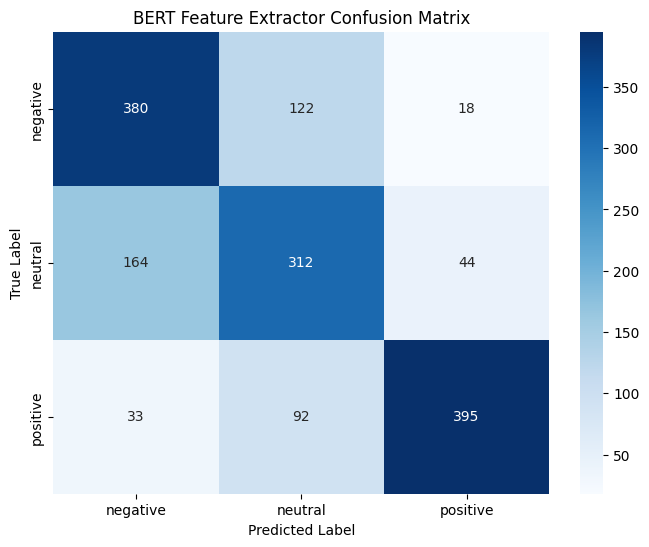

array([[380, 122,  18],
       [164, 312,  44],
       [ 33,  92, 395]])

In [ ]:
# Evaluate
evaluate_model(y_test, test_preds_bert, 'BERT Feature Extractor')

In [ ]:
# Save Model
save_directory = '/content/drive/MyDrive/baseline_models/bert_feature_extractor'
os.makedirs(save_directory, exist_ok=True)
classifier.save(f'{save_directory}/classifier.keras')
tokenizer.save_pretrained(save_directory)
print(f'BERT classifier and tokenizer saved to {save_directory}')

BERT classifier and tokenizer saved to /content/drive/MyDrive/baseline_models/bert_feature_extractor
